# Методы интерпретации нейронных сетей

В лабораторной работе предлагается обучить классификатор медицинских изображений на одной из баз MedMNIST (либо другой медицинской базы), применить методы интерпретации нейронных сетей и сопоставить результаты этих методов.

Возможен анализ работы предобученной модели нейронной сети, решающей интересную для вас задачу классификации медицинских изображений.

Удобно использовать реализации методов интерпретации из библиотеки MONAI, специализованной под медицинские задачи (но можно воспользоваться и другими аналогичными библиотеками).

Необходимо исследовать работу обученной нейросетевой модели с помощью методов:
- `OcclusionSensitivity`,
- `GradCAM++`.


Пример обучения нейросетевой модели на MedMNIST из документации:

https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

Примеры использования методов интерпретации из документации проекта MONAI:

https://github.com/Project-MONAI/tutorials/blob/main/modules/interpretability/covid_classification.ipynb

https://github.com/Project-MONAI/tutorials/blob/main/modules/interpretability/class_lung_lesion.ipynb


## Установка зависимостей

In [1]:
from IPython.display import clear_output

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import sklearn" || pip install -q scikit-learn

clear_output()

In [3]:
!pip install medmnist

clear_output()

## Импорт библиотек

In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision

In [5]:
import medmnist
from medmnist import INFO, Evaluator
from medmnist import BloodMNIST

In [6]:
from monai.config import print_config
from matplotlib import pyplot as plt
from monai.visualize import GradCAMpp, OcclusionSensitivity

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-06-02 16:06:36.574597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748880396.802096      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748880396.864550      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## TODO
#### Создайте необходимые для обучения, валидации и тестирования объекты классов Dataset, DataLoader

In [8]:
batch_size = 128
imsize = 64

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

info = INFO['bloodmnist']
num_classes = len(info['label'])

train_set = BloodMNIST(split="train", download=True, size=imsize, transform=transform)
val_set = BloodMNIST(split="val", download=True, size=imsize, transform=transform)
test_set = BloodMNIST(split="test", download=True, size=imsize, transform=transform)

dataloader_train = DataLoader(train_set, shuffle=True, batch_size=128)
dataloader_val = DataLoader(val_set, shuffle=False, batch_size=128)
dataloader_test = DataLoader(test_set, shuffle=False, batch_size=128)

100%|██████████| 156M/156M [00:36<00:00, 4.34MB/s]


## TODO
#### Создайте объекты классов модели (самостоятельно задав архитектуру сети либо выбрав готовую модель), функции потерь, оптимизатора

In [9]:
model = torchvision.models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

for name, param in model.named_parameters():
    if not name.startswith('fc.'):
        param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


## TODO
#### Обучите модель, реализовав циклы обучения и валидации

In [10]:
num_epochs = 20
freeze_epochs = 10
learning_rate = 1e-3

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [11]:
def compute_accuracy(logits, targets):
    preds = torch.argmax(logits, dim=1) 
    return (preds == targets).float().mean().item()

In [12]:
for epoch in range(1, num_epochs + 1):
    if epoch == freeze_epochs + 1:
        for param in model.parameters(): param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/10)
        print(f"Epoch {epoch}: unfreezing")

    model.train()
    for images, targets in dataloader_train:
        images = images.to(device)
        targets = targets.to(device).squeeze(1) 

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    val_acc, val_batches = 0.0, 0
    with torch.no_grad():
        for images, targets in dataloader_val:
            images = images.to(device)
            targets = targets.to(device).squeeze(1) 
            outputs = model(images)
            val_acc += compute_accuracy(outputs, targets)
            val_batches += 1
    val_acc /= val_batches
    
    print(f"Epoch {epoch}/{num_epochs} | Val Acc: {val_acc:.4f}")

Epoch 1/20 | Val Acc: 0.7433
Epoch 2/20 | Val Acc: 0.7613
Epoch 3/20 | Val Acc: 0.7684
Epoch 4/20 | Val Acc: 0.7786
Epoch 5/20 | Val Acc: 0.7766
Epoch 6/20 | Val Acc: 0.7909
Epoch 7/20 | Val Acc: 0.7844
Epoch 8/20 | Val Acc: 0.7883
Epoch 9/20 | Val Acc: 0.7846
Epoch 10/20 | Val Acc: 0.7896
Epoch 11: unfreezing
Epoch 11/20 | Val Acc: 0.9187
Epoch 12/20 | Val Acc: 0.9364
Epoch 13/20 | Val Acc: 0.9360
Epoch 14/20 | Val Acc: 0.9414
Epoch 15/20 | Val Acc: 0.9395
Epoch 16/20 | Val Acc: 0.9408
Epoch 17/20 | Val Acc: 0.9395
Epoch 18/20 | Val Acc: 0.9373
Epoch 19/20 | Val Acc: 0.9382
Epoch 20/20 | Val Acc: 0.9435


In [13]:
test_acc, test_batches = 0.0, 0
with torch.no_grad():
    for images, targets in dataloader_test:
        images = images.to(device)
        targets = targets.to(device).squeeze(1)
        outputs = model(images)
        test_acc += compute_accuracy(outputs, targets)
        test_batches += 1
    test_acc /= test_batches

print(f"Test Acc: {test_acc:.4f}")

Test Acc: 0.9465


In [14]:
model = model.to('cpu')

# Интерпретируемость

Необходимо сравнить разные методы интерпретации.

## Чувствительность к окклюзии (Occlusion sensitivity)
В этом методе интерпретации последовательно перекрывается часть изображения, а затем отслеживается изменение в предсказанной вероятности предполагаемого класса. Ожидается, что вероятность будет больше снижаться при перекрытии важных частей изображения. Следовательно, синие части изображения характеризуются большей важностью.


## GradCAM
Пользователь выбирает слой сети, который его интересует, и для этого слоя выполняется оценка значимости областей. Обычно выбирается слой из числа последних, так как предполагается, что к этому моменту будут извлечены все необходимые признаки. В сверточных нейронных сетях карты признаков многократно подвергаются уменьшению, поэтому результирующее изображение карты значимости масштабируется в соответствии с размером входного изображения. Как и в случае с чувствительностью к окклюзии, синие участки изображения характеризуются большей важностью для процесса принятия решений.


В отличие от MONAI, в других реализациях методов интерпретации чаще красные оттенки областей соответствуют большим значимостям.

Хорошее объяснение CAM и GradCAM:

https://glassboxmedicine.com/2019/06/11/cnn-heat-maps-class-activation-mapping-cam/

https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/

In [15]:
target_layer = "layer3"
gradcampp = GradCAMpp(model, target_layers=target_layer)
occ_sens = OcclusionSensitivity(
    model,
    mask_size=8,
    n_batch=16,
    overlap=0.75,
    verbose=False,
)

In [16]:
def saliency(model, d):
    ims = []

    img = torch.as_tensor(d[0].unsqueeze(0)).to('cpu')

    pred_logits = model(img)
    pred_label = pred_logits.argmax(dim=1).item()
    pred_prob = int(torch.nn.functional.softmax(pred_logits, dim=1)[0, pred_label].item() * 100)
    # Image
    ims.append(img[0])

    gt_label = int(d[1][0])
    massage = f"GT: {info['label'][str(gt_label)]}, "
    massage += f"pred: {info['label'][str(pred_label)]} ({pred_prob}%)"
    print(massage)

    # Occlusion sensitivity images
    occ_map, _ = occ_sens(img)
    ims.append(occ_map[0, pred_label][None])

    # GradCAM
    res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
    ims.append(res_cam_pp)

    return ims

GT: eosinophil, pred: eosinophil (99%)


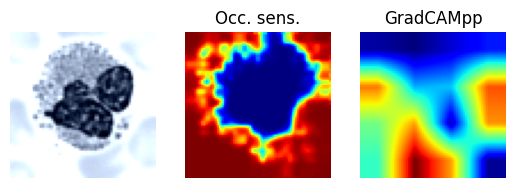

GT: eosinophil, pred: eosinophil (99%)


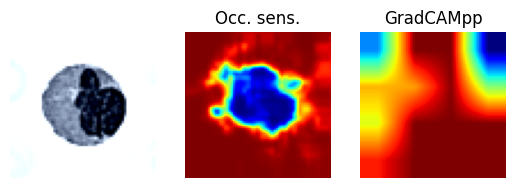

GT: basophil, pred: basophil (99%)


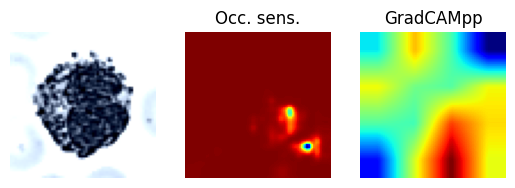

GT: immature granulocytes(myelocytes, metamyelocytes and promyelocytes), pred: immature granulocytes(myelocytes, metamyelocytes and promyelocytes) (80%)


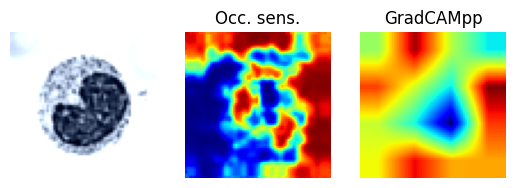

GT: eosinophil, pred: eosinophil (100%)


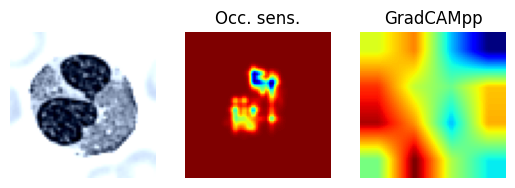

In [17]:
rnd_idxs = np.random.randint(0, high=len(test_set), size=5)

for idx in rnd_idxs:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)

    d = test_set[idx]

    ims = saliency(model, d)

    im = ims[0].detach().cpu().numpy().transpose(1, 2, 0)
    im = im * 0.5 + 0.5
    ax1.imshow(im)
    ax1.axis("off")

    im = ims[1].detach().cpu().numpy().transpose(1, 2, 0)
    ax2.imshow(im, "jet")
    ax2.set_title("Occ. sens.")
    ax2.axis("off")

    im = ims[2].detach().cpu().numpy().transpose(1, 2, 0)
    ax3.imshow(im, "jet")
    ax3.set_title("GradCAMpp")
    ax3.axis("off")
    plt.show()

#### В ходе выполнения лабораторной работы были изучены два метода визуализации важности признаков в свёрточных нейронных сетях: Occlusion Sensitivity (анализ чувствительности к закрашиванию) и Grad-CAM (градиентно-взвешенная визуализация областей интереса). Occlusion Sensitivity является модельно-независимым подходом, который позволяет оценить влияние различных участков изображения на предсказание модели. Метод заключается в последовательном закрашивании частей изображения (серым цветом или шумом) и анализе изменения уверенности модели. Области, при закрытии которых точность классификации значительно снижается, считаются наиболее важными для принятия решения. Этот метод прост в реализации и интерпретации, но требует значительных вычислительных затрат из-за необходимости множественного перекрытия и повторного прогона изображения через модель. GradCAM, в отличие от первого метода, использует внутренние механизмы CNN, а именно градиенты по входному изображению, для построения тепловой карты значимости. Этот подход позволяет выделить наиболее информативные области без модификации исходного изображения, что делает его более эффективным с вычислительной точки зрения. Однако он зависит от архитектуры модели, так как требует доступа к промежуточным активациям и градиентам.